In [2]:
import numpy as np
import pandas as pd
# install pandas_ta - https://github.com/twopirllc/pandas-ta
import pandas_ta as ta

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import mlflow
import time

import optuna

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.signal import periodogram

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.inspection import permutation_importance

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize

# Pipelines
from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

# Metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_score, accuracy_score, recall_score, f1_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier


# Algorithmic Trading Bot

## TODO: 1. Introduction

## 2. Methodology and Research Design

## 3. Data Acquisition

## 4. Data Processing

First, gather historical Bitcoin price data, which will be used for model training. Ideally, this data should include:

1. **Price Data**: Open, close, high, and low prices over specific time intervals (e.g., daily, hourly).
2. **Trading Volumes**: The amount of Bitcoin traded during the respective time intervals.
3. **Technical Indicators**: Calculate indicators like RSI, MACD, Moving Averages, etc., commonly used for trading decisions.

You can use APIs from **Binance**, **Coinbase Pro**, or **Yahoo Finance** to download this data.

### 1.1. Gather historical Bitcoin price data

**Price Data**: Gathered the open, close, high, and low prices over specific time intervals (every minute)

In [3]:
btc_price_data_1_year = pd.read_csv("data/bitcoin_historical_data_1_year.csv")
btc_price_data_1_year

,timestamp,open,high,low,close,volume,date,time
0,2023-11-01 00:00:00,34618.86,34676.51,34656.38,34667.88,48.953000,2023-11-01,00:00:00
1,2023-11-01 00:01:00,34642.54,34687.53,34673.30,34642.82,16.178075,2023-11-01,00:01:00
2,2023-11-01 00:02:00,34637.97,34656.82,34642.53,34656.56,8.753120,2023-11-01,00:02:00
3,2023-11-01 00:03:00,34617.22,34656.56,34656.56,34629.34,11.308610,2023-11-01,00:03:00
4,2023-11-01 00:04:00,34597.99,34630.42,34629.41,34622.27,8.583808,2023-11-01,00:04:00
...,...,...,...,...,...,...,...,...
528627,2024-10-31 23:56:00,70238.76,70248.97,70248.97,70238.76,1.189134,2024-10-31,23:56:00
528628,2024-10-31 23:57:00,70218.00,70250.00,70238.77,70233.24,4.767082,2024-10-31,23:57:00
528629,2024-10-31 23:58:00,70193.97,70242.25,70232.55,70207.78,9.589688,2024-10-31,23:58:00
528630,2024-10-31 23:59:00,70175.16,70207.79,70207.79,70197.83,7.112237,2024-10-31,23:59:00


In [4]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,528632.0,57052.764723,11061.821828,34079.460000,44083.780000,61015.800000,66127.655000,73718.320000
high,528632.0,57100.379874,11072.504219,34133.680000,44119.545000,61066.475000,66178.047500,73835.570000
low,528632.0,57076.624894,11067.091134,34113.930000,44103.265000,61041.025000,66153.502500,73815.030000
close,528632.0,57076.858348,11067.114019,34114.860000,44103.380000,61041.340000,66154.337500,73815.430000
volume,528632.0,8.915933,17.137792,0.001083,1.730652,4.020989,9.541108,1163.832604


In [5]:
btc_price_data_1_year.dtypes

timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
date          object
time          object
dtype: object

In [6]:
btc_price_data_1_year.isnull().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
date         0
time         0
dtype: int64

## 2. Data Preparation

### 2.1. Data Tidying and Cleaning

Convert the `timestamp` column from *object* type to *datetime64* type.

In [7]:
btc_price_data_1_year.timestamp = pd.to_datetime(btc_price_data_1_year.timestamp)

`date` and `time` columns are not needed. We will drop them.

In [8]:
btc_price_data_1_year = btc_price_data_1_year.drop(columns = ["date", "time"])

In [9]:
btc_price_data_1_year.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
close               float64
volume              float64
dtype: object

Set `timestamp` as index.

In [10]:
btc_price_data_1_year.set_index('timestamp', inplace=True, drop = True)

In [11]:
# Ensure the data is sorted by time
btc_price_data_1_year = btc_price_data_1_year.sort_index()

### 2.2. Plot Bitcoin Price

In [12]:
def plot_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    x_lim_start = dates[0]
    x_lim_end = dates[len(dates) - 1]
    # plt.xlim(x_lim_start, x_lim_end)
    ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates, prices)
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.show()

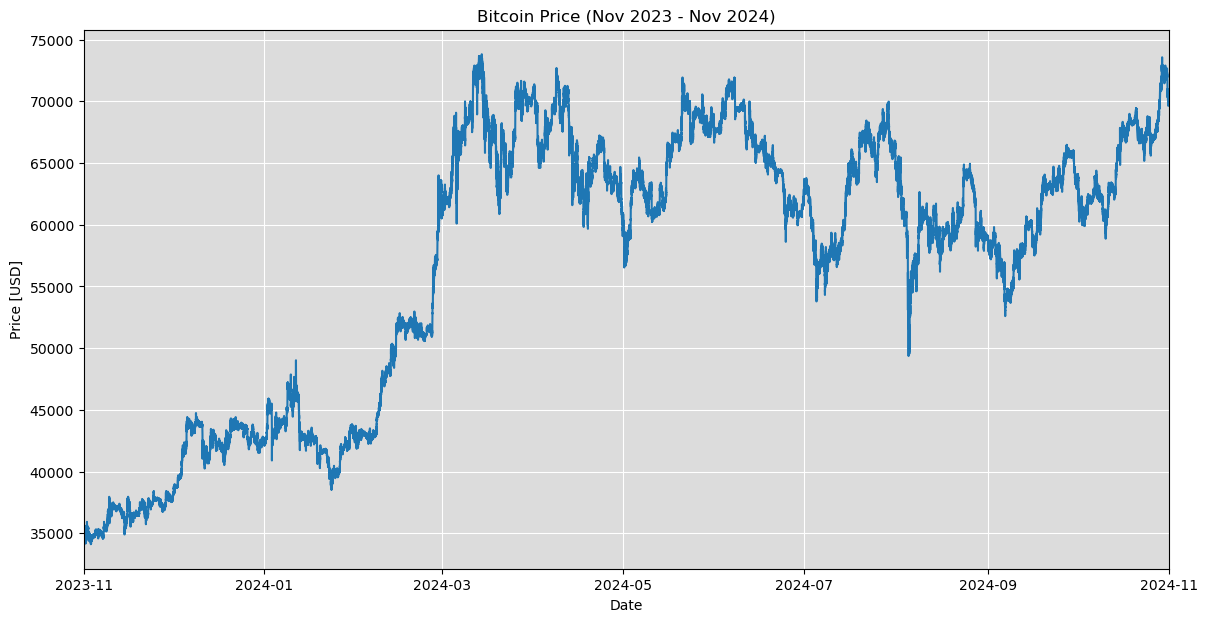

In [13]:
dates = btc_price_data_1_year.index
prices_close_btc = btc_price_data_1_year.close
title_btc = 'Bitcoin Price (Nov 2023 - Nov 2024)'

labels = ['Date', 'Price [USD]']

plot_market_data(dates, prices_close_btc, labels, title_btc)

## 3. Feature Engineering

### 3.1. Seasonality and Trends

#### 3.1.1. Extract the components of the datetime

We extract various components of the datetime, such as the year, month, day, hour, and day of the week. This can help the model capture seasonality and trends.

In [15]:
btc_price_data_1_year['month'] = btc_price_data_1_year.index.month
btc_price_data_1_year['day'] = btc_price_data_1_year.index.day
btc_price_data_1_year['weekday'] = btc_price_data_1_year.index.weekday  # Monday=0, Sunday=6
btc_price_data_1_year['hour'] = btc_price_data_1_year.index.hour

For time-based features like hour of day, day of the week, and month, we can use cyclical encoding. This ensures that values like 23:00 and 00:00 are considered "close" to each other, rather than being far apart numerically.

In [16]:
# Extract hour and weekday
btc_price_data_1_year['hour_sin'] = np.sin(2 * np.pi * btc_price_data_1_year.index.hour / 24)  # Hour sin encoding
btc_price_data_1_year['hour_cos'] = np.cos(2 * np.pi * btc_price_data_1_year.index.hour / 24)  # Hour cos encoding
btc_price_data_1_year['weekday_sin'] = np.sin(2 * np.pi * btc_price_data_1_year.index.weekday / 7)  # Weekday sin encoding
btc_price_data_1_year['weekday_cos'] = np.cos(2 * np.pi * btc_price_data_1_year.index.weekday / 7)  # Weekday cos encoding

#### 3.1.2. STL (Seasonal-Trend decomposition using LOESS)

**STL** stands for **Seasonal-Trend decomposition using LOESS**. It's a robust statistical method used to decompose a time series into three components:

1. **Seasonal Component**: Represents the repeating pattern in the data over a fixed period (e.g., daily, weekly, monthly).
2. **Trend Component**: Captures the long-term progression in the data, showing an overall increase, decrease, or stability over time.
3. **Remainder/Residual Component**: Represents the part of the data that cannot be attributed to either seasonality or trend, often considered as noise.

**Key Features of STL**
- **Flexible**: Allows decomposition of time series with any type of seasonal pattern, not limited to a fixed frequency.
- **Robust**: Resistant to outliers in the data.
- **Local Regression (LOESS)**: Uses locally weighted regression to smooth the data during decomposition.

**Applications**
- **Forecasting**: By isolating the trend and seasonal components, forecasting models can be more accurate.
- **Anomaly Detection**: The remainder component helps identify unusual spikes or dips.
- **Visualization**: Simplifies understanding of the data by breaking it into interpretable parts.

In [19]:
# Apply STL decomposition
stl = STL(btc_price_data_1_year['close'], robust=True, period = 24)  # period=24 for daily seasonality in hourly data
result = stl.fit()

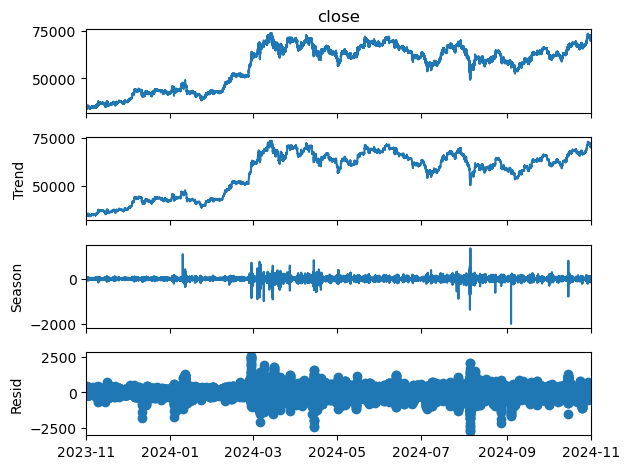

In [20]:
# Extract components
btc_price_data_1_year['trend'] = result.trend
btc_price_data_1_year['seasonal'] = result.seasonal
btc_price_data_1_year['residual'] = result.resid

# Plot the decomposition
result.plot()
plt.show()

In [21]:
# 1.Lagged Features - Lagged values of the trend, seasonal, and residual
for lag in range(1, 4):  # Use 1, 2, 3 hours as lags
    btc_price_data_1_year[f'trend_lag_{lag}'] = btc_price_data_1_year['trend'].shift(lag)
    btc_price_data_1_year[f'seasonal_lag_{lag}'] = btc_price_data_1_year['seasonal'].shift(lag)
    btc_price_data_1_year[f'residual_lag_{lag}'] = btc_price_data_1_year['residual'].shift(lag)

# 2.Rolling Statistics - Rolling mean and standard deviation of each component.
btc_price_data_1_year['trend_rolling_mean'] = btc_price_data_1_year['trend'].rolling(window=24).mean()
btc_price_data_1_year['residual_rolling_std'] = btc_price_data_1_year['residual'].rolling(window=24).std()

# 3.Differences - Calculate the difference between close price and its trend or seasonality
btc_price_data_1_year['close_trend_diff'] = btc_price_data_1_year['close'] - btc_price_data_1_year['trend']
btc_price_data_1_year['close_seasonal_diff'] = btc_price_data_1_year['close'] - btc_price_data_1_year['seasonal']

### 3.2. Autocorrelation

Autocorrelation in time series refers to the correlation of a time series with a lagged version of itself. It measures how past values of the series influence current values. Understanding autocorrelation can help identify patterns, trends, and periodicity in time-series data.

##### Why Autocorrelation Matters
- **Pattern Detection**: Helps identify repeating patterns or seasonality.
- **Modeling Assumptions**: Many models (like ARIMA) assume specific autocorrelation structures.
- **Feature Engineering**: Insights from autocorrelation can guide the creation of lag-based features for machine learning models.

##### Types of Autocorrelation
1. **Positive Autocorrelation**: High values follow high values, and low values follow low values.
2. **Negative Autocorrelation**: High values follow low values, and vice versa.
3. **No Autocorrelation**: Values are independent of each other.

##### How to Measure Autocorrelation
The **autocorrelation function (ACF)** and the **partial autocorrelation function (PACF)** are two common tools:

###### 1. **Autocorrelation Function (ACF)**
- Measures the correlation between the time series and its lagged values.
- Useful for identifying the overall pattern of dependence at different lags.

###### 2. **Partial Autocorrelation Function (PACF)**
- Measures the correlation between the time series and its lagged values after removing the influence of shorter lags.
- Useful for determining the direct relationship between a value and a specific lag.


Set the count of the **lags** that will be considered during the Autocorrelation anylysis:

In [24]:
# We use the last 3 days (3 * 24 hours) for the autocorrelation analysis
lags = 72

#### 3.2.1. Autocorrelation Function (ACF)

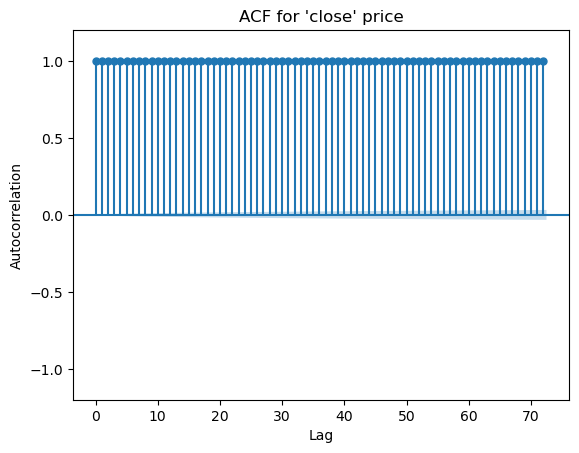

In [25]:
plot_acf(btc_price_data_1_year.close, lags = lags)
plt.ylim(-1.2, 1.2)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF for \'close\' price')
plt.show()

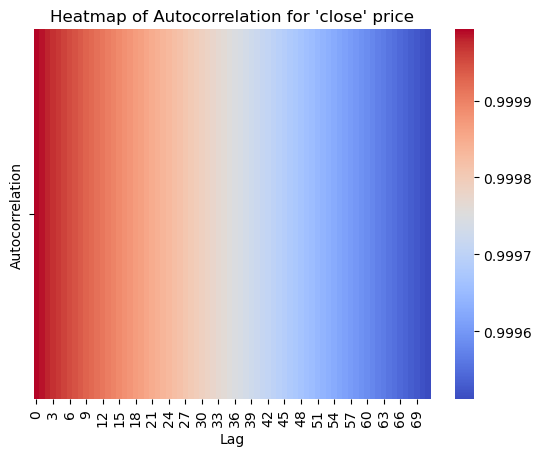

In [26]:
autocorr = [btc_price_data_1_year['close'].autocorr(lag) for lag in range(1, lags+1)]
sns.heatmap(pd.DataFrame(autocorr, columns=["Autocorrelation"]).T, annot=False, cmap="coolwarm")
plt.xlabel('Lag')
plt.title('Heatmap of Autocorrelation for \'close\' price')
plt.show()

If the autocorrelation is very large we use partial autocorrelation.

#### 3.2.2. Partial Autocorrelation Function (PACF)

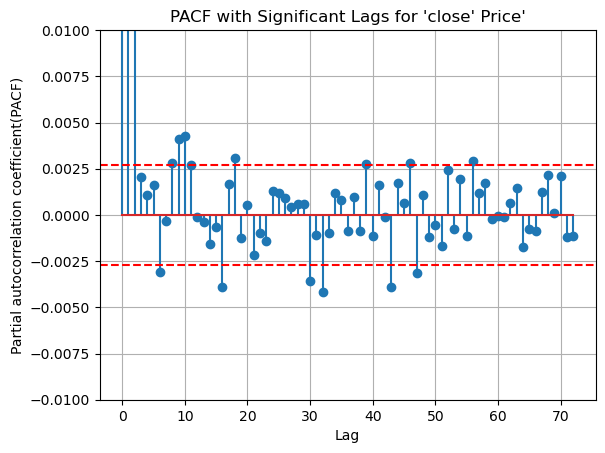

Significant Lags: [ 0  1  2  6  8  9 10 16 18 30 32 39 43 46 47 56]


In [28]:
# Calculate PACF
pacf_values = pacf(btc_price_data_1_year['close'], nlags=lags)

# Calculate the confidence interval
conf_int = 1.96 / np.sqrt(len(btc_price_data_1_year['close']))  # The 95% confidence interval

# Get significant lags (values outside the confidence interval)
significant_lags = np.where(np.abs(pacf_values) > conf_int)[0]

# Plot PACF with significant lags marked
plt.stem(pacf_values)

plt.axhline(y=conf_int, color='r', linestyle='--')
plt.axhline(y=-conf_int, color='r', linestyle='--')
plt.ylim(-0.010, 0.010)

plt.grid()

plt.xlabel('Lag')
plt.ylabel('Partial autocorrelation coefficient(PACF)')
plt.title("PACF with Significant Lags for \'close\' Price'")
plt.show()

# Print the significant lags
print("Significant Lags:", significant_lags)

**Significant lags**: Spikes that are outside the area between the two red lines are **statistically significant** at the 95% confidence level.

Correlation coefficients that are between the two red lines are **insignificant** for the model. In this area the **p-value** is too small. Correlations in this area may well be random.

In [29]:
# Remove the autocorrelation with itself (the '0'-th lag)
significant_lags = significant_lags[1:] if significant_lags[0] == 0 else significant_lags
print("Significant Lags:", significant_lags)

Significant Lags: [ 1  2  6  8  9 10 16 18 30 32 39 43 46 47 56]


In [30]:
# Create lag features (past values as features)
def create_lag_features(df, lags = []):
    """
    Create lag features (past values as features)
    """
    # Create a copy of the DataFrame
    df_copy = df.copy(deep=True)
    
    for lag in lags:
        df_copy[f'lag_{lag}'] = df_copy['close'].shift(lag)
        
    #df.dropna(inplace=True)
    return df_copy

In [31]:
btc_price_data_1_year = create_lag_features(btc_price_data_1_year, significant_lags)

### 3.3. Calculate Technical Indicators

Calculate the values and add new columns with calculated values for **RSI**, **MACD**, **Moving Averages** and other relevant indicators.

#### 3.3.1. Relative Strength Index (RSI)

**RSI** is a momentum oscillator that measures the speed and change of recent price movements. It is used to identify overbought or oversold conditions in a stock's price, generally over a 14-day period.

- **Formula**: The RSI is calculated as:
  
  $$\text{RSI} = 100 - \frac{100}{1 + RS}$$
  
  where $RS$ (Relative Strength) is the ratio of **average gains** to **average losses** over the lookback period (e.g., 14 days).

- **Interpretation**:
  - **Overbought Condition**: When RSI is above 70, the asset is often considered overbought, suggesting a potential for a pullback.
  - **Oversold Condition**: When RSI is below 30, the asset is considered oversold, suggesting a potential for a rebound.

- **Calculation**:
  - Calculate the **change** in price from one day to the next.
  - Separate the changes into **gains** (positive changes) and **losses** (negative changes).
  - Compute the **average gain** and **average loss** over the 14-day period.
  - Calculate \( RS \) as the ratio of average gain to average loss.
  - Use the RSI formula to convert \( RS \) into an index between 0 and 100.

In [34]:
def calculate_rsi(data, window=14):
    """
    RSI is a momentum oscillator that measures the speed and change of price movements, typically over a 14-period interval.
    Assuming 'data' is a DataFrame with a 'close' price column

    Parameters
    ----------
    data:   a DataFrame with the time series data. A column with the name 'close' must be present in the DataFrame! 
            This column is used to calculate the 'RSI' value.
    window: the time period that is taken into account when calculating the 'RSI'
    """
    delta = data['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    
    return data

In [35]:
# Calculate RSI
btc_price_data_1_year = calculate_rsi(btc_price_data_1_year)

#### 3.3.2. Moving Average Convergence Divergence (MACD)

**MACD** is a trend-following momentum indicator that shows the relationship between two moving averages of an asset’s price.

- **Formula**:
  - **MACD Line**: $\text{MACD} = \text{EMA}_{\text{short}} - \text{EMA}_{\text{long}}$
  - **Signal Line**: A **9-day EMA** of the MACD line.
  - **MACD Histogram**: The difference between the MACD line and the Signal Line.

  Here, EMA stands for Exponential Moving Average, which gives more weight to recent prices.

- **Common Parameters**:
  - **Short EMA**: Often set to a 12-day EMA.
  - **Long EMA**: Often set to a 26-day EMA.
  - **Signal Line EMA**: Often set to a 9-day EMA of the MACD line.

- **Interpretation**:
  - **MACD Line Crosses Above Signal Line**: This is a bullish signal, indicating a potential buy.
  - **MACD Line Crosses Below Signal Line**: This is a bearish signal, indicating a potential sell.
  - **MACD Divergence**: If the price and MACD are moving in opposite directions, it may signal a reversal.
  - **Histogram**: The MACD histogram shows the distance between the MACD line and the Signal Line. When the histogram grows larger, it indicates a strengthening trend in that direction.

- **Application**:
  - The MACD helps traders see changes in momentum, trend direction, and possible reversal points by analyzing the difference between the short and long EMAs.

In [36]:
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    """
    Moving Average Convergence Divergence (MACD) is calculated using two exponential moving averages (EMA):
    the 12-day EMA and the 26-day EMA, with a 9-day EMA as the signal line.
    """
    data['EMA12'] = data['close'].ewm(span=short_window, adjust=False).mean()
    data['EMA26'] = data['close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD Line
    data['MACD'] = data['EMA12'] - data['EMA26']
    
    # Signal Line
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    return data

In [37]:
# Calculate MACD (Moving Average Convergence Divergence)
btc_price_data_1_year = calculate_macd(btc_price_data_1_year)

#### 3.3.3. Moving Averages (SMA and EMA)

Moving averages smooth out price data to help identify trends over specific time frames. They are often used to see the underlying trend of an asset’s price and are among the most widely used technical indicators.

##### 2.2.3.1. Simple Moving Average (SMA)

- **Definition**: The **SMA** is the average of the closing prices over a specific period. For example, a 10-day SMA is the average closing price over the last 10 days.
  
- **Formula**:
  $$\text{SMA} = \frac{\sum_{i=1}^{N} \text{Price}_i}{N}$$
  where $N$ is the period (e.g., 10 days).

- **Interpretation**:
  - **Trend Identification**: When prices are above the SMA, it suggests an upward trend; when below, it suggests a downward trend.
  - **Crossovers**: When a short-term SMA crosses above a long-term SMA (e.g., 10-day SMA crosses above the 50-day SMA), it generates a bullish signal. The reverse crossover indicates a bearish signal.

##### 2.2.3.2. Exponential Moving Average (EMA)

- **Definition**: The **EMA** is a weighted moving average that gives more importance to recent prices, making it more responsive to new information than the SMA.
  
- **Formula**:
  - EMA uses a multiplier:
    $$\text{EMA}_\text{current} = \left(\frac{2}{N+1}\right) \times (\text{Price}_\text{current} - \text{EMA}_\text{previous}) + \text{EMA}_\text{previous}$$
    where $N$ is the number of periods.

- **Interpretation**:
  - **More Sensitive to Price Changes**: Because the EMA responds more quickly to recent prices, it is useful in identifying potential reversals and shorter-term trends.

In [38]:
def calculate_moving_averages(data, sma_window=20, ema_window=20):
    """
    Simple Moving Average (SMA) is the average price over a specified number of periods, 
    while Exponential Moving Average (EMA) gives more weight to recent prices.
    """
    # Simple Moving Average
    data['SMA'] = data['close'].rolling(window=sma_window).mean()
    
    # Exponential Moving Average
    data['EMA'] = data['close'].ewm(span=ema_window, adjust=False).mean()
    
    return data

In [39]:
# Calculate moving averages
btc_price_data_1_year = calculate_moving_averages(btc_price_data_1_year)

## 4. Calculate Target Variable

In [42]:
def create_target_variable_with_techn_indicators_hourly(data, price_threshold = 0.01):
    """
    Computes and sets the 'target' variable from the input 'data' and 'threshold'.
    Creates a 'target' column with the computed values in the 'data' DataFrame.

    Parameters
    ----------
    data: a DataFrame with the time series data. There must be a column named 'close'! 
          This column will be used by the user to calculate the 'target' variable.
    
    threshold: threshold for the price change to classify as 'buy' or 'sell'. For instance, if you want a 1% increase to be a 'buy' signal,
               the threshold will be 0.01. Adjust this threshold as per your strategy.
    """
    # Create a copy of the DataFrame
    data_copy = data.copy(deep=True)
    
    # Compute the percentage change between the current close price and the close price in the next period.
    # This will help define whether there’s a significant increase or decrease.
    data_copy['future_return'] = ((data_copy['close'].shift(-1) - data_copy['close']) / data_copy['close']) * 100
    
    # Use the technical indicators to add more conditions to the target:
    # - RSI: A Relative Strength Index (RSI) value below 30 often indicates an oversold condition, which might suggest a buying opportunity.
    # - MACD: A positive MACD value (i.e., MACD > Signal Line) can suggest an uptrend.
    # - SMA/EMA: If the current price is above the SMA or EMA, it may indicate an upward trend.
    #data_copy['buy_signal'] = (
    conditions_buy  = (
        (data_copy['future_return'] > price_threshold) &
        #(data_copy['RSI'] < 30) &   # buy signal for RSI
        (data_copy['RSI'] < 40) &    # buy signal for RSI
        ((data_copy['MACD'] > data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) <= data_copy['Signal_Line'].shift(1))) #& # buy signal for MACD
        # ((data_copy['close'] > data_copy['SMA']) & (data_copy['close'].shift(1) <= data_copy['SMA'].shift(1))) # buy signal for SMA
    ).astype(int)

    conditions_sell  = (
        (data_copy['future_return'] < - price_threshold) &
        #(data_copy['RSI'] > 70) &    # sell signal for RSI 
        (data_copy['RSI'] > 60) &     # sell signal for RSI 
        (data_copy['MACD'] < data_copy['Signal_Line']) & (data_copy['MACD'].shift(1) >= data_copy['Signal_Line'].shift(1)) #& # sell signal for MACD 
        # (data_copy['close'] < data_copy['SMA']) & (data_copy['close'].shift(1) >= data_copy['SMA'].shift(1)) # sell signal for SMA 
    ).astype(int)

    # Define the 'target' as 1 (buy), 0(do nothing) and -1(sell).
    # Initialize the 'target' column with default value
    data_copy['target'] = 0 # 'do nothing' signal
    
    # Fill the 'target' with the 'buy_signal' and 'sell_signal' conditions 
    data_copy.loc[(conditions_buy == 1) & (conditions_sell == 0), 'target'] = 1 # 'buy' signal
    data_copy.loc[(conditions_sell == 1) & (conditions_buy == 0), 'target'] = 2 # 'sell' signal

    # Generate signals
    # data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
    # data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell

    # The last row in your dataset will have a NaN value for 'future_return' due to the shift operation. Drop this row to clean up the dataset.
    # data_copy = data_copy.dropna()

    # Print the balance of 1s, 0s and -1s in our 'target' variable to understand how many 'buy' and 'sell' signals we have.
    print(data_copy['target'].value_counts())

    return data_copy

In [43]:
# Define the threshold for the price change to classify as 'buy' or 'sell'. For instance, if we want a 1% increase to be a 'buy' signal,
# the threshold will be 0.01.
threshold = 0.01

# Compute the 'target' variable
btc_price_data_1_year = create_target_variable_with_techn_indicators_hourly(btc_price_data_1_year, threshold)

target
0    525868
2      1458
1      1306
Name: count, dtype: int64


## 5. Clean up the Data

In [44]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,528632.0,57052.764723,11061.821828,34079.460000,44083.780000,6.101580e+04,66127.655000,73718.320000
high,528632.0,57100.379874,11072.504219,34133.680000,44119.545000,6.106648e+04,66178.047500,73835.570000
low,528632.0,57076.624894,11067.091134,34113.930000,44103.265000,6.104102e+04,66153.502500,73815.030000
close,528632.0,57076.858348,11067.114019,34114.860000,44103.380000,6.104134e+04,66154.337500,73815.430000
volume,528632.0,8.915933,17.137792,0.001083,1.730652,4.020989e+00,9.541108,1163.832604
month,528632.0,6.513584,3.451354,1.000000,4.000000,7.000000e+00,10.000000,12.000000
day,528632.0,15.753742,8.810303,1.000000,8.000000,1.600000e+01,23.000000,31.000000
weekday,528632.0,2.996814,1.995341,0.000000,1.000000,3.000000e+00,5.000000,6.000000
hour,528632.0,11.497507,6.921663,0.000000,5.000000,1.100000e+01,17.000000,23.000000
hour_sin,528632.0,0.000209,0.707107,-1.000000,-0.707107,1.224647e-16,0.707107,1.000000


In [45]:
btc_price_data_1_year.dtypes

open                    float64
high                    float64
low                     float64
close                   float64
volume                  float64
month                     int32
day                       int32
weekday                   int32
hour                      int32
hour_sin                float64
hour_cos                float64
weekday_sin             float64
weekday_cos             float64
trend                   float64
seasonal                float64
residual                float64
trend_lag_1             float64
seasonal_lag_1          float64
residual_lag_1          float64
trend_lag_2             float64
seasonal_lag_2          float64
residual_lag_2          float64
trend_lag_3             float64
seasonal_lag_3          float64
residual_lag_3          float64
trend_rolling_mean      float64
residual_rolling_std    float64
close_trend_diff        float64
close_seasonal_diff     float64
lag_1                   float64
lag_2                   float64
lag_6   

In [46]:
btc_price_data_1_year.shape

(528632, 53)

In [47]:
btc_price_data_1_year.isnull().sum()

open                     0
high                     0
low                      0
close                    0
volume                   0
month                    0
day                      0
weekday                  0
hour                     0
hour_sin                 0
hour_cos                 0
weekday_sin              0
weekday_cos              0
trend                    0
seasonal                 0
residual                 0
trend_lag_1              1
seasonal_lag_1           1
residual_lag_1           1
trend_lag_2              2
seasonal_lag_2           2
residual_lag_2           2
trend_lag_3              3
seasonal_lag_3           3
residual_lag_3           3
trend_rolling_mean      23
residual_rolling_std    23
close_trend_diff         0
close_seasonal_diff      0
lag_1                    1
lag_2                    2
lag_6                    6
lag_8                    8
lag_9                    9
lag_10                  10
lag_16                  16
lag_18                  18
l

There are some rows in the dataset that have a `NaN` values (`future_return`, `RSI`, `SMA` and some `lag`-columns) due to the feature engineering process. We will delete these rows to clean up the dataset.

In [48]:
btc_price_data_1_year = btc_price_data_1_year.dropna()

In [49]:
btc_price_data_1_year.shape

(528575, 53)

In [50]:
btc_price_data_1_year.isnull().sum()

open                    0
high                    0
low                     0
close                   0
volume                  0
month                   0
day                     0
weekday                 0
hour                    0
hour_sin                0
hour_cos                0
weekday_sin             0
weekday_cos             0
trend                   0
seasonal                0
residual                0
trend_lag_1             0
seasonal_lag_1          0
residual_lag_1          0
trend_lag_2             0
seasonal_lag_2          0
residual_lag_2          0
trend_lag_3             0
seasonal_lag_3          0
residual_lag_3          0
trend_rolling_mean      0
residual_rolling_std    0
close_trend_diff        0
close_seasonal_diff     0
lag_1                   0
lag_2                   0
lag_6                   0
lag_8                   0
lag_9                   0
lag_10                  0
lag_16                  0
lag_18                  0
lag_30                  0
lag_32      

In [51]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'month', 'day', 'weekday',
       'hour', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'trend',
       'seasonal', 'residual', 'trend_lag_1', 'seasonal_lag_1',
       'residual_lag_1', 'trend_lag_2', 'seasonal_lag_2', 'residual_lag_2',
       'trend_lag_3', 'seasonal_lag_3', 'residual_lag_3', 'trend_rolling_mean',
       'residual_rolling_std', 'close_trend_diff', 'close_seasonal_diff',
       'lag_1', 'lag_2', 'lag_6', 'lag_8', 'lag_9', 'lag_10', 'lag_16',
       'lag_18', 'lag_30', 'lag_32', 'lag_39', 'lag_43', 'lag_46', 'lag_47',
       'lag_56', 'RSI', 'EMA12', 'EMA26', 'MACD', 'Signal_Line', 'SMA', 'EMA',
       'future_return', 'target'],
      dtype='object')

## 6. Backtesting

final_balance after: 2408.5268377132434
Final Balance with 1h data: $2408.53
Final Return with 1h data: $140.85[%]


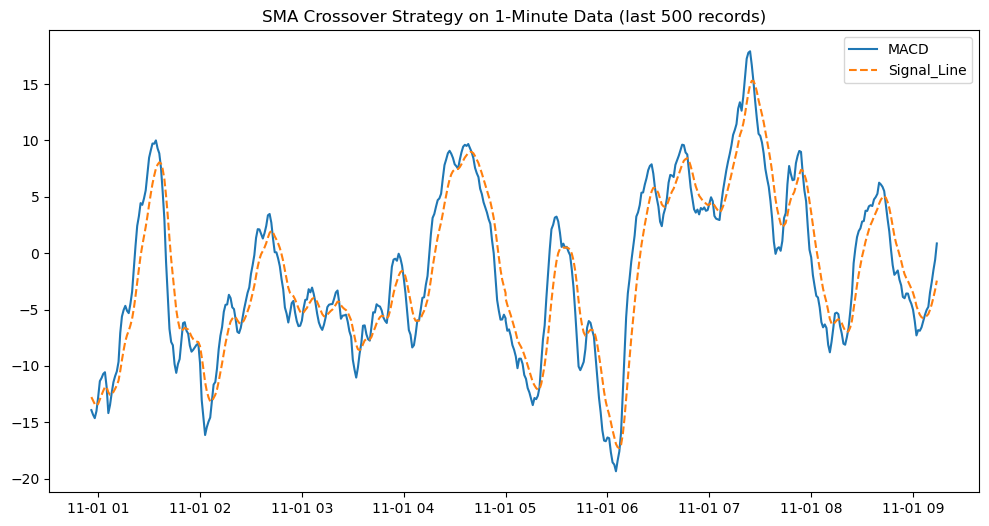

In [54]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# Load your Bitcoin dataset (assume columns: 'timestamp', 'close', 'high', 'low', 'volume')
# df = pd.read_csv('bitcoin_price.csv')
# df['timestamp'] = pd.to_datetime(df['timestamp'])
# df.set_index('timestamp', inplace=True)

df = btc_price_data_1_year

# # Resample the data to different timeframes
# def resample_data(data, timeframe='15T'):
#     return data.resample(timeframe).mean()

    # return data.resample(timeframe).agg({
    #     'close': 'last', 
    #     'high': 'max', 
    #     'low': 'min', 
    #     'volume': 'sum'
    # }).dropna()

# # Apply a simple moving average crossover strategy
# def sma_crossover_strategy(data, short_window=10, long_window=50):
#     data['SMA_short'] = data['close'].rolling(window=short_window).mean()
#     data['SMA_long'] = data['close'].rolling(window=long_window).mean()
    
#     # Generate signals
#     data['signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)
#     data['signal'] = data['signal'].diff()  # 1 = Buy, -1 = Sell
#     return data

# Backtest the strategy
def backtest(data, initial_balance=1000):
    print(f"Initial Balance Balance: ${initial_balance:.2f}")
    
    balance = initial_balance
    position = 0  # Number of Bitcoin held
    count = 0
    for i in range(1, len(data)):
        # print("target: ", data.target)
        if data['target'].iloc[i] == 1 and balance > 0:  # Buy signal
            count = count + 1
            #print("count buy:", count)
            
           # print("Buy signal balance:", balance)
            position = balance / data['close'].iloc[i]
           # print("Buy signal position:", position)
           # print("--------------------------------")
            balance = 0
        elif data['target'].iloc[i] == 2 and position > 0:  # Sell signal
            count = count + 1
           # print("count sell:", count)
            
           # print("Sell signal position:", position)
            balance = position * data['close'].iloc[i]
          #  print("Sell signal balance:", balance)
          #  print("--------------------------------")
            position = 0
    # Final portfolio value
    final_balance = balance + (position * data['close'].iloc[-1])
    #print("final_balance after:", final_balance)
    return final_balance

# Test on multiple timeframes
timeframes = [ '1h']
# timeframes = ['1min', '5min', '15min', '1h', '4h', '1D']
results = {}

for timeframe in timeframes:
    # df_resampled = resample_data(df, timeframe)
    # df_strategy = sma_crossover_strategy(df_resampled)
    # final_balance = backtest(df_strategy)
    # print(df_resampled.shape)
    # Compute the 'target' variable
    # df_strategy = create_target_variable_with_techn_indicators(df_resampled, threshold)
    final_balance = backtest(df)
    results[timeframe] = final_balance

# Print results
for timeframe, balance in results.items():
    print(f"Final Balance with {timeframe} data: ${balance:.2f}")
    final_return = ((balance - 1000) / 1000) * 100
    print(f"Final Return with {timeframe} data: {final_return:.2f}[%]")

# Visualize a selected timeframe (e.g., 15-minute data)
# df_strategy = sma_crossover_strategy(resample_data(df, '15T'))
# df_strategy = resample_data(df, '1h')
plt.figure(figsize=(12, 6))
# plt.plot(df_strategy['close'], label='Close Price')
plt.plot(df['MACD'][:500], label='MACD', linestyle='-')
plt.plot(df['Signal_Line'][:500], label='Signal_Line', linestyle='--')
plt.legend()
plt.title('SMA Crossover Strategy on 1-Minute Data (last 500 records)')
plt.show()

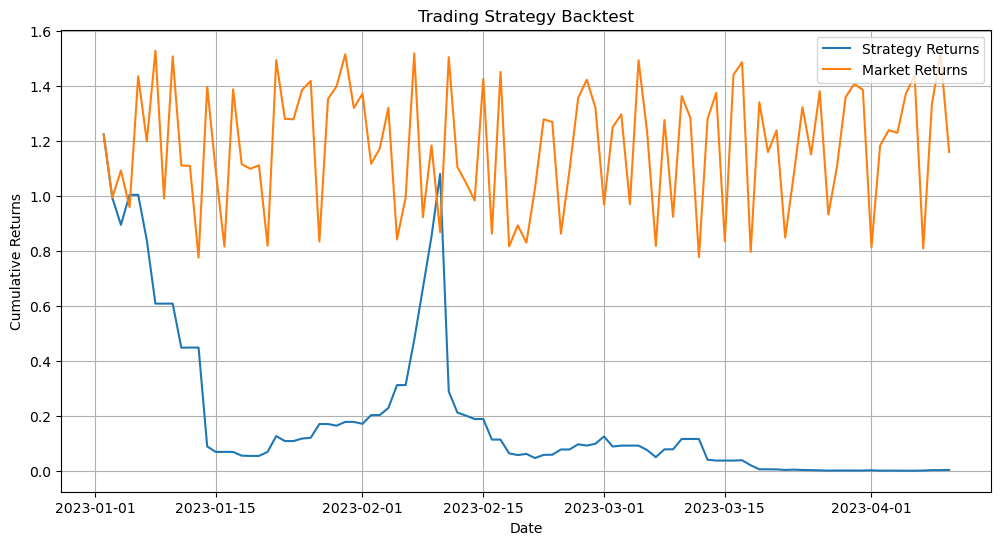

Total Return: -99.55%
Sharpe Ratio: -0.02


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample historical data
data = pd.DataFrame({
    'timestamp': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'close_price': np.random.uniform(100, 200, 100),
    'signal': np.random.choice([-1, 0, 1], 100),  # Buy (1), Hold (0), Sell (-1)
})

# Calculate daily returns
data['market_returns'] = data['close_price'].pct_change()

# Apply trading signals
data['strategy_returns'] = data['signal'].shift(1) * data['market_returns']

# Calculate cumulative returns
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()
data['cumulative_market_returns'] = (1 + data['market_returns']).cumprod()

# Plot equity curves
plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['cumulative_strategy_returns'], label='Strategy Returns')
plt.plot(data['timestamp'], data['cumulative_market_returns'], label='Market Returns')
plt.title('Trading Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

# Performance Metrics
total_return = data['cumulative_strategy_returns'].iloc[-1] - 1
sharpe_ratio = data['strategy_returns'].mean() / data['strategy_returns'].std()
print(f"Total Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


## 7. Data Preprocessing for the Predictive Model

### 7.1. Dataset Preparation

The dataset has **528.575** records. The **target** variable has 3 possible values - **0**, **1** and **2**. The values are strongly imbalanced. 

| Class | Count     | Percentage | 
|-------|-----------|------------|
|   0   | 525812    |  99,48 %   | 
|   1   | 1305      |  0,25 %    | 
|   2   | 1458      |  0,28 %    | 

#### 7.1.1 Save Attributes and Target DataFrames

In [55]:
attributes = btc_price_data_1_year.drop(columns=['target'])  # Features
target = btc_price_data_1_year['target']  # Target variable

In [56]:
target

timestamp
2023-11-01 00:56:00    0
2023-11-01 00:57:00    0
2023-11-01 00:58:00    0
2023-11-01 00:59:00    0
2023-11-01 01:00:00    0
                      ..
2024-10-31 23:55:00    0
2024-10-31 23:56:00    0
2024-10-31 23:57:00    0
2024-10-31 23:58:00    0
2024-10-31 23:59:00    0
Name: target, Length: 528575, dtype: int64

In [57]:
def save_data(df, filename='bitcoin_historical_data.csv'):
    """
    Saves data with a backup file
    """
    # Save file
    # df.to_csv(filename, index=False)
    df.to_csv(filename)
    
    print(f"Data saved to {filename}")

In [58]:
# Save the features to a csv file
save_data(attributes, filename = 'data/btc_price_data_1_year_attributes.csv')

Data saved to data/btc_price_data_1_year_attributes.csv


In [59]:
# Save the target variable to a csv file
save_data(target, filename = 'data/btc_price_data_1_year_target.csv')

Data saved to data/btc_price_data_1_year_target.csv


#### 7.1.1 Data Splitting

In [61]:
attributes_train, attributes_test, target_train, target_test = train_test_split(
    attributes, 
    target, 
    test_size=0.2, 
    shuffle = False,
    random_state = 42
)

In [62]:
attributes_train.shape, attributes_test.shape

((422860, 52), (105715, 52))

In [63]:
target_train.shape, target_test.shape

((422860,), (105715,))

Plot the splitted data:

In [110]:
def plot_splitted_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    # x_lim_start = dates[0][0]
    # x_lim_end = dates[1][len(dates[1]) - 1]
    # # x_lim_end = dates[len(dates[0]) + len(dates[1]) - 1]
    # # plt.xlim(x_lim_start, x_lim_end)
    # ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    # plt.plot(attributes_train.index, attributes_train.close)
    # plt.plot(attributes_test.index, attributes_test.close)
    plt.plot(dates[0], prices[0])
    plt.plot(dates[1], prices[1])
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.show()

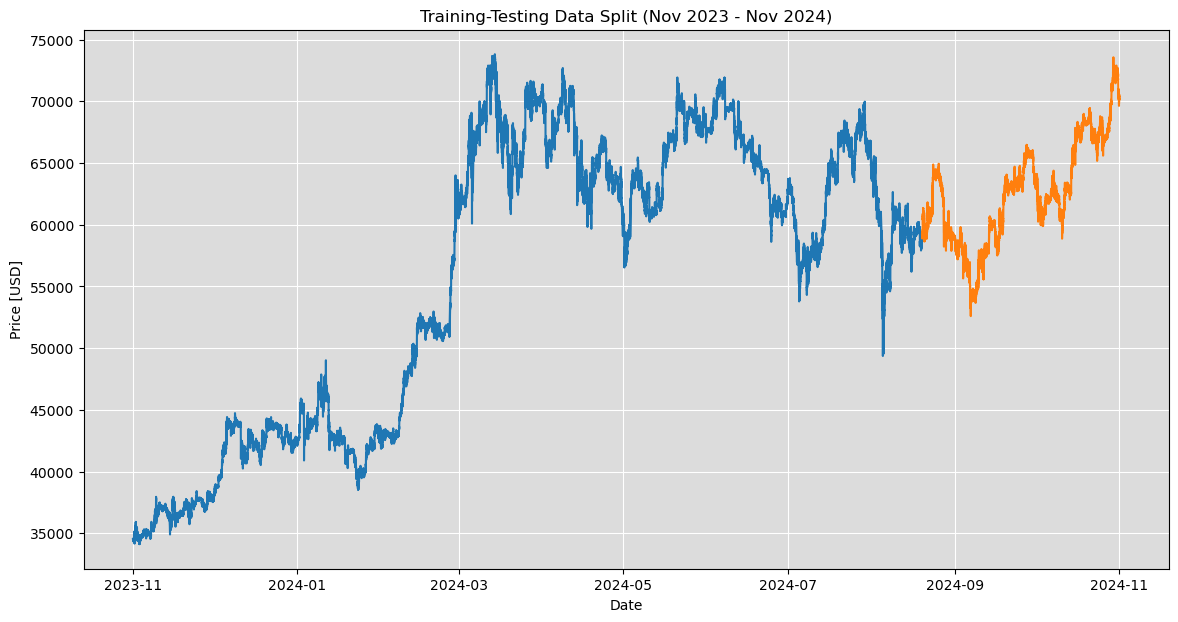

In [111]:
dates_train = attributes_train.index
prices_close_train = attributes_train.close

dates_test = attributes_test.index
prices_close_test = attributes_test.close

dates = [dates_train, dates_test]
prices_close_btc = [prices_close_train, prices_close_test]

title_btc = 'Training-Testing Data Split (Nov 2023 - Nov 2024)'

labels = ['Date', 'Price [USD]']

plot_splitted_market_data(dates, prices_close_btc, labels, title_btc)

### 7.2. Oversampling - Address Class Imbalance

Since the data set is very unbalanced, we will use oversampling to generate synthetic data for the minority classes.

**SMOTE** (Synthetic Minority Oversampling Technique) and **ADASYN** (Adaptive Synthetic Sampling) are two popular oversampling techniques for addressing class imbalance in datasets. Both generate synthetic samples for the minority class to balance the dataset, but they differ in how they create these samples. Below is a detailed comparison to help you understand their strengths and use cases.

##### **Core Approach**

###### **SMOTE**
- **How it works**: 
  - For each minority class sample, SMOTE selects one or more nearest neighbors.
  - It creates synthetic samples by interpolating between the sample and its neighbors.
  - The interpolation is linear, producing samples along the line segments between the selected points.
- **Focus**: Generates synthetic samples evenly across the minority class.

###### **ADASYN**
- **How it works**: 
  - ADASYN builds on SMOTE by focusing more on the minority class samples that are harder to classify.
  - It identifies minority samples near the decision boundary (using k-nearest neighbors) and generates more synthetic samples in these regions.
  - The number of synthetic samples per instance is proportional to the local difficulty (measured by the density of majority class samples nearby).
- **Focus**: Creates samples adaptively, concentrating on areas where the minority class is harder to learn.

##### **Key Differences**

| Feature                     | **SMOTE**                                  | **ADASYN**                                      |
|-----------------------------|---------------------------------------------|------------------------------------------------|
| **Generation Strategy**     | Uniformly interpolates between samples.     | Focuses on generating samples near decision boundaries. |
| **Focus**                   | Balances the dataset evenly.               | Adaptive oversampling based on instance difficulty.      |
| **Synthetic Sample Location** | Can lead to over-generalization.           | More targeted and refined near complex regions. |
| **Computational Complexity**| Relatively lower computational cost.        | Slightly higher due to the adaptive nature.     |
| **Risk of Overfitting**     | Higher risk if the boundary is noisy.       | Reduced overfitting near decision boundaries.   |

##### **Strengths**

###### **SMOTE**
- **Advantages**:
  - Simple and effective for moderately imbalanced datasets.
  - Maintains the distribution of the minority class.
- **When to Use**:
  - When the imbalance is not extreme.
  - When you want a more uniform oversampling approach.

###### **ADASYN**
- **Advantages**:
  - Focuses on challenging regions, improving the model's ability to classify difficult cases.
  - Reduces the risk of overgeneralization by targeting specific areas.
- **When to Use**:
  - For highly imbalanced datasets.
  - When the minority class has complex boundaries or is under-represented in critical regions.

##### **Limitations**

###### **SMOTE**
- Does not consider the difficulty of classification.
- Can create synthetic samples in regions that are already well-represented, potentially leading to redundancy.
- May cause overfitting in noisy datasets.

###### **ADASYN**
- Slightly more computationally expensive than SMOTE.
- If the data is very noisy, it might generate samples in misleading or non-representative regions.

#### 7.2.1. SMOTE (Synthetic Minority Oversampling Technique)

In [8]:
def create_oversampling_smote(attributes_train, target_train):
    """
    Apply SMOTE(Synthetic Minority Oversampling Technique) to generate synthetic examples for minority classes
    """
    smote = SMOTE(random_state=42)
    attributes_train_smote, target_train_smote = smote.fit_resample(attributes_train, target_train)
    
    print("Original Class Distribution (SMOTE):", np.bincount(target_train))
    print("Balanced Class Distribution (SMOTE):", np.bincount(target_train_smote))

    return attributes_train_smote, target_train_smote

#### 7.2.2. ADASYN (Adaptive Synthetic Sampling)

In [9]:
def create_oversampling_adasyn(attributes_train, target_train):
    """
    Apply ADASYN(Adaptive Synthetic Sampling) to generate synthetic examples for minority classes
    """
    adasyn = ADASYN(random_state=42)
    attributes_train_adasyn, target_train_adasyn = adasyn.fit_resample(attributes_train, target_train)
    
    print("Original Class Distribution (ADASYN):", np.bincount(target_train))
    print("Balanced Class Distribution (ADASYN):", np.bincount(target_train_adasyn))

    return attributes_train_adasyn, target_train_adasyn

#### 7.2.3. Set Oversampling Type

In [10]:
def create_oversampling(attributes_train, target_train, oversampling_type = None):
    """
    Apply 'oversampling_type' to generate synthetic examples for minority classes
    """
    if oversampling_type == 'smote':
        return create_oversampling_smote(attributes_train, target_train)
    elif oversampling_type == 'adasyn':
        return create_oversampling_adasyn(attributes_train, target_train)
    else:
        print(f"Invalid oversampling type: [{oversampling_type}]")
        return attributes_train, target_train

### 7.3. Selecting Score Function

Choosing the best scoring function for an imbalanced model depends on our specific goals, the nature of the imbalance, and how important it is to accurately identify minority classes. Below is an overview of the most suitable metrics for unbalanced datasets with multi-class classification:

1. **Macro F1 Score**
    - **Description**: The F1 score is the harmonic mean of precision and recall. The macro version calculates the F1 score for each class independently and then averages them, giving equal weight to all classes, regardless of their size.
    - **Best Use Case**: Use when all classes are equally important, and you want to evaluate the model's ability to perform well across all classes.
2. **Balanced Accuracy**
    - **Description**: Balanced accuracy is the average of recall obtained on each class. It accounts for class imbalance by giving equal weight to each class.
    - **Best Use Case**: Use when the focus is on recall for all classes, ensuring minority classes are not overlooked.
3. **Weighted F1 Score**
    - **Description**: Similar to the macro F1 score, but the weighted version accounts for the number of samples in each class. Larger classes have more influence on the score.
    - **Best Use Case**: Use when the performance on larger classes is also important, but you still want some recognition of minority classes.
4. **Log Loss (Cross-Entropy Loss)**
    - **Description**: Log loss evaluates the probabilistic predictions of the model rather than hard predictions. It penalizes confident but incorrect predictions more heavily.
    - **Best Use Case**: Use when the quality of probability estimates is important (e.g., when the model's confidence in predictions is valuable).
5. **Cohen's Kappa**
    - **Description**: Cohen's Kappa measures the agreement between predicted and actual labels while accounting for the agreement occurring by chance. It's a robust metric for imbalanced datasets.
    - **Best Use Case**: Use when you want to assess model performance relative to chance performance.
6. **ROC AUC (One-vs-Rest or Macro)**
    - **Description**: Measures the model's ability to distinguish between classes. For multiclass problems, you can calculate a macro-average or use the one-vs-rest (OvR) approach.
    - **Best Use Case**: Use when evaluating the model’s ranking ability and when probabilistic predictions are available.

##### Choosing the Best Metric
1. **When All Classes Are Equally Important**:
   - Use **Macro F1 Score** or **Balanced Accuracy**. These metrics give equal weight to all classes, ensuring fair evaluation of minority classes.

2. **When Minority Classes Are Critical**:
   - Use **Macro F1 Score** or **Cohen's Kappa**. These metrics are sensitive to performance on minority classes.

3. **When Probabilistic Predictions Matter**:
   - Use **Log Loss** or **ROC AUC**. These metrics evaluate the quality of the predicted probabilities.

4. **When Class Proportions Matter**:
   - Use **Weighted F1 Score**. It balances class importance based on their frequencies.

Recommendation for our **highly imbalanced dataset** (Class 0: 526k, Class 1: 1,3k, Class 2: 1,5k):
- Start with **Macro F1 Score**: This ensures that all classes, including the minority ones, are equally weighted during evaluation.
- Combine it with **Balanced Accuracy**: To verify the recall for minority classes.
- Optionally, calculate **Cohen's Kappa** to assess how much better the model is compared to chance.

##### Final Decision

We will use the **Macro F1 Score**. This is typically the most interpretable and fair metric for imbalanced datasets, especially when minority class performance is critical.

### 7.4. Classification Report

A **classification report** is a performance evaluation metric used to summarize the results of a classification model. It provides insights into how well the model is performing for each class in terms of precision, recall, F1-score, and support. Here's an explanation of the key metrics:

1. **Precision**
    - **Definition**: Precision measures the accuracy of positive predictions. It tells us what proportion of predicted positive instances are actually positive.
    - **Interpretation**: High precision indicates that the model is making very few false positive errors.
    - **Formula**: $$\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}$$

2. **Recall (Sensitivity or True Positive Rate)**
    - **Definition**: Recall measures the ability of the model to capture all positive instances. It tells us what proportion of actual positive instances were correctly identified.
    - **Interpretation**: High recall indicates that the model captures most of the positive instances.
    - **Formula**:  $$\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}$$

3. **F1-Score**
    - **Definition**: The F1-score is the harmonic mean of precision and recall. It provides a single metric that balances the trade-off between precision and recall.
    - **Interpretation**: A high F1-score indicates a good balance between precision and recall. It is particularly useful when the class distribution is imbalanced.
    - **Formula**: $$\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

4. **Support**
    - **Definition**: Support is the number of actual occurrences of each class in the dataset. It indicates the size of the ground truth data for each class.
    - **Interpretation**: While support is not a performance metric, it helps in understanding how many instances belong to each class, which is essential for analyzing model performance in the context of imbalanced datasets.



##### **Example of a Classification Report**
Here’s a typical classification report:

| Class      | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|---------|
| Class 0    | 0.95      | 0.98   | 0.96     | 200     |
| Class 1    | 0.87      | 0.75   | 0.81     | 100     |
| **Macro Avg** | 0.91      | 0.86   | 0.89     | 300     |
| **Weighted Avg** | 0.93      | 0.93   | 0.93     | 300     |

##### **Notes on Key Averages:**
1. **Macro Average**:
   - Arithmetic mean of the metrics across all classes (unweighted).
   - Treats all classes equally regardless of support.
2. **Weighted Average**:
   - Weighted mean of the metrics, considering the support of each class.
   - Reflects overall performance while accounting for class imbalance.

## 8. Model Selection

For our imbalanced dataset, an appropriate model needs to either inherently handle class imbalance or be complemented by techniques to mitigate the issue. We will focus on three models: **XGBoost**, **Random Forest**, and **LightGBM**.

##### 1. **Random Forest**:
   - **Strengths**:
     - Simple to implement and interpret, as it uses multiple decision trees.
     - Can be adapted for imbalanced datasets using `class_weight` in Scikit-learn (`balanced` or `balanced_subsample`).
     - Handles noisy data and large feature sets well.
   - **Weaknesses**:
     - May underperform on extremely imbalanced datasets if not carefully tuned or augmented with sampling techniques.
     - Less flexible compared to gradient boosting models for fine-grained adjustments.

##### 2. **XGBoost**:
   - **Strengths**:
     - Offers built-in functionality for handling imbalanced datasets via the `scale_pos_weight` parameter, which adjusts the weight for each class based on their frequencies.
     - Performs well on tabular datasets and handles non-linear relationships effectively.
     - Robust to overfitting due to regularization options (`lambda`, `alpha`).
   - **Weaknesses**:
     - Computationally expensive, especially for large datasets.
     - Tuning the hyperparameters (e.g., learning rate, max depth) can be time-consuming.

##### 3. **LightGBM**:
   - **Strengths**:
     - Specifically designed for speed and scalability, making it faster than XGBoost on large datasets.
     - Like XGBoost, supports `scale_pos_weight` to handle imbalance.
     - Optimized for sparse datasets and performs well with categorical features.
     - Often achieves similar or better accuracy compared to XGBoost with fewer computational resources.
   - **Weaknesses**:
     - More sensitive to hyperparameter tuning compared to Random Forest.
     - May require careful preprocessing of data to avoid overfitting.

##### Comparison Table:

| Model         | Handles Imbalance (Directly) | Speed/Scalability | Interpretability | Hyperparameter Sensitivity | Performance on Imbalance (Post-Tuning) |
|---------------|-------------------------------|-------------------|------------------|----------------------------|-------------------------------|
| Random Forest | Yes (`class_weight`)         | Moderate          | High             | Low                        | Good                           |
| XGBoost       | Yes (`scale_pos_weight`)     | Medium            | Moderate         | High                       | Excellent                      |
| LightGBM      | Yes (`scale_pos_weight`)     | High              | Moderate         | High                       | Excellent                      |

#### 7.2.1. RandomForestClassifier

##### Recommendations:
1. **LightGBM**: For large, imbalanced datasets, it is faster and often more accurate than XGBoost. It would be a strong alternative.
2. **Imbalance Techniques**:
   - Use **oversampling** (SMOTE, ADASYN) or **undersampling** to balance the dataset.
   - Alternatively, apply **cost-sensitive learning** via weight adjustments in models.
3. **Evaluation Metrics**:
   - Use metrics like **F1-score**, **AUC-ROC**, or **balanced accuracy** to assess model performance, as accuracy is not meaningful for imbalanced data.
4. **Ensemble Approaches**:
   - Combine multiple models (e.g., stacking XGBoost, LightGBM, and Random Forest) for potentially better predictions.

#### 7.2.1.2. feature_importances_

In [74]:
# Visualize feature importances
def plot_feature_importances(model, scaler_name = 'StandardScaler'):
    
    # print(f"Feature Importances for {scaler_name}:")
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(attributes_train.shape[1]), importances[sorted_indices], align='center')
    plt.xticks(range(attributes_train.shape[1]), attributes.columns[sorted_indices], rotation=90)
    plt.title(f"Feature Importances ({scaler_name})")
    plt.tight_layout()
    plt.show()


In [75]:
#plot_feature_importances(model)

In [76]:
#model.feature_importances_.sum()

In [77]:
#result_feat_imp = list(zip(btc_price_data_1_year.columns, np.round(model.feature_importances_, 3)))

In [78]:
#pd.DataFrame(result_feat_imp).sort_values(1, ascending = False)

#### 7.2.1.3 Hyperparameter Optimization (RandomForestClassifier)

#### 7.2.2. XGBoost

#### 7.2.2.1. Train Model

Set time series-specific hyperparameters and tune them for your data:

#### 7.2.2.2. Evaluate the Model

#### 7.3.1. Create a Pipeline for RandomForestClassifier

In [ ]:
#model = RandomForestClassifier(n_estimators=10, random_state=42)

In [ ]:
model_pipeline_randomforest = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("forest", RandomForestClassifier(
            class_weight='balanced', n_estimators = 300, max_depth = 10, min_samples_split = 2, random_state=42, n_jobs = 9)),
        # ("forestClass", RandomForestClassifier(n_estimators=10, min_samples_split= 50, random_state=42)),
        # ("scaler", StandardScaler()),
        # ("svd", TruncatedSVD(n_components = 20)),
        # ("nb", SGDClassifier(loss = "hinge"))
    ]
)

### 3.4. Step 4: Model Evaluation

1. **Making Predictions**:
   - Use the model to make predictions on the test dataset.

In [ ]:
predictions = model_pipeline.predict(attributes_test)
print(predictions)

In [ ]:
print("Unique classes:", np.unique(predictions))

2. **Evaluating Performance**:
   - Use metrics for binary model evaluation, such as accuracy, precision, recall, and F1-score.

In [ ]:
# Check with train data
print(classification_report(target_train, model.predict(attributes_train)))

In [ ]:
print(classification_report(target_test, model.predict(attributes_test)))

In [ ]:
target_test.value_counts()

In [ ]:
accuracy = accuracy_score(target_test, predictions)
precision = precision_score(target_test, predictions, average='macro')
recall = recall_score(target_test, predictions, average='macro')
f1 = f1_score(target_test, predictions, average='macro')
   
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

## 4. Step 4: Strategy Simulation (Backtesting)

Before deploying the bot in a live environment, backtest it to assess its performance on historical data.

1. **Use the Test Dataset**: Evaluate how the bot would perform if buy and sell decisions had been made based on historical data.
2. **Evaluate the Strategy**: Calculate key metrics like:
   - **Return**: Compare achieved profit relative to a baseline (e.g., buy-and-hold).
   - **Maximum Drawdown**: Assess the largest losses during consecutive failed trades.
   - **Risk/Reward Ratio**.

Backtesting is the process of evaluating the performance of a predictive model or trading strategy using historical data. In your case, since you're working with a machine learning model (e.g., LightGBM), backtesting involves simulating how your model's predictions would have performed on unseen data, particularly in the context of time-series or trading applications.

---

### **Why Perform Backtesting?**
1. **Assess Real-World Applicability:** Understand how well your model performs in scenarios resembling actual usage.
2. **Avoid Data Leakage:** Ensure your model generalizes well without benefiting from information it wouldn't have in a live setting.
3. **Evaluate Profitability or Utility:** If your model is used in trading or decision-making, backtesting helps measure potential gains or losses.

---

### **Key Steps in Backtesting**

#### **1. Define the Backtesting Framework**
- **Prediction Horizon:** Decide how far into the future the model is predicting (e.g., next minute, hour, or day).
- **Evaluation Metrics:** Define metrics to measure performance, such as F1-score, precision, recall, or financial metrics like profit, Sharpe ratio, etc.

#### **2. Split Data Appropriately**
In time-series data, the order of the data matters. Use methods like:
- **Rolling Window Validation:** Train on a rolling window of data and validate on the next segment.
- **Walk-Forward Validation:** Incrementally extend the training data and predict on the next time step.
  
Example:
- Train on `data[0:100]` and test on `data[101:110]`.
- Train on `data[0:110]` and test on `data[111:120]`.

#### **3. Simulate Predictions**
- Use your trained model to predict the target values for the test set.
- For trading, convert predictions into buy/sell/hold decisions.

#### **4. Evaluate Performance**
- Compare predictions with actual outcomes.
- For trading strategies, compute:
  - **Profit/Loss:** How much you would have gained or lost using the predictions.
  - **Hit Rate:** Percentage of correct predictions.
  - **Drawdown:** Maximum loss experienced during the strategy.
  - **Sharpe Ratio:** Measure of risk-adjusted return.

---

### **Simple Backtesting Example**

#### **Example Setup**
Suppose your model predicts a trading signal:  
- **Buy (1)**: Buy the asset.  
- **Sell (-1)**: Sell the asset.  
- **Hold (0)**: Do nothing.

#### **Code for Backtesting**

```python
import numpy as np
import pandas as pd

# Example dataset with model predictions and actual prices
data = pd.DataFrame({
    'timestamp': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'close_price': np.random.uniform(100, 200, 100),  # Simulated prices
    'signal': np.random.choice([-1, 0, 1], 100),     # Model predictions
})

# Calculate daily returns
data['returns'] = data['close_price'].pct_change()

# Apply model signals to compute strategy returns
data['strategy_returns'] = data['signal'].shift(1) * data['returns']

# Calculate cumulative returns
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()
data['cumulative_market_returns'] = (1 + data['returns']).cumprod()

# Performance Metrics
total_return = data['cumulative_strategy_returns'].iloc[-1] - 1
sharpe_ratio = data['strategy_returns'].mean() / data['strategy_returns'].std()

print(f"Total Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['cumulative_strategy_returns'], label='Strategy')
plt.plot(data['timestamp'], data['cumulative_market_returns'], label='Market')
plt.legend()
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid()
plt.show()
```

---

### **Best Practices**
1. **Train/Test Separation:** Ensure your model predictions are truly out-of-sample by using proper time splits.
2. **Transaction Costs:** Include costs like fees or slippage to reflect real-world conditions.
3. **Robust Metrics:** Evaluate using multiple metrics (e.g., precision, recall, F1-score, financial metrics).
4. **Multiple Scenarios:** Backtest across various market conditions (bullish, bearish, sideways).

Would you like to adapt this code for your dataset or analyze specific aspects like transaction costs or trading metrics?

Total Return: -99.99%
Sharpe Ratio: -0.11


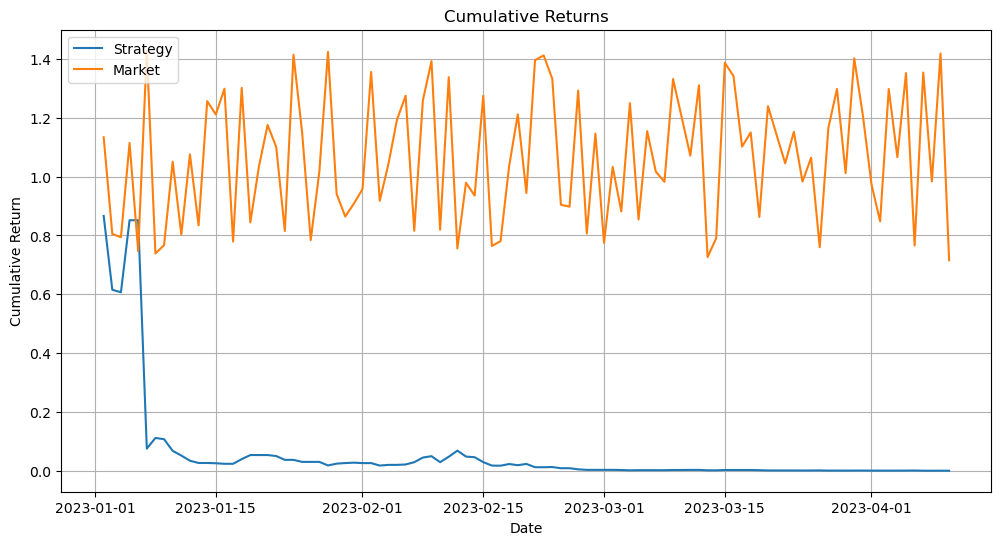

In [114]:
import numpy as np
import pandas as pd

# Example dataset with model predictions and actual prices
data = pd.DataFrame({
    'timestamp': pd.date_range(start='2023-01-01', periods=100, freq='D'),
    'close_price': np.random.uniform(100, 200, 100),  # Simulated prices
    'signal': np.random.choice([-1, 0, 1], 100),     # Model predictions
})

# Calculate daily returns
data['returns'] = data['close_price'].pct_change()

# Apply model signals to compute strategy returns
data['strategy_returns'] = data['signal'].shift(1) * data['returns']

# Calculate cumulative returns
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()
data['cumulative_market_returns'] = (1 + data['returns']).cumprod()

# Performance Metrics
total_return = data['cumulative_strategy_returns'].iloc[-1] - 1
sharpe_ratio = data['strategy_returns'].mean() / data['strategy_returns'].std()

print(f"Total Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['timestamp'], data['cumulative_strategy_returns'], label='Strategy')
plt.plot(data['timestamp'], data['cumulative_market_returns'], label='Market')
plt.legend()
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid()
plt.show()

## 9. Further improvements

### 9.1. Focal Loss

Great! Let's proceed with implementing **focal loss** in LightGBM. Since LightGBM doesn’t natively support focal loss, we need to define it as a custom objective function. Below is a step-by-step guide:

---

### **Step-by-Step Focal Loss Implementation**

#### **1. Define the Focal Loss Function**
The focal loss focuses more on hard-to-classify samples by modulating the loss based on the prediction probability. 

Here’s the implementation:
```python
import numpy as np

def focal_loss(alpha, gamma):
    """
    Focal Loss for LightGBM

    Parameters:
    - alpha: Weighting factor for the minority class (0 < alpha <= 1).
    - gamma: Focusing parameter to reduce the relative loss for well-classified samples (gamma >= 0).

    Returns:
    - Custom focal loss function compatible with LightGBM.
    """
    def focal_loss_lgbm(y_true, y_pred):
        # Convert predictions to probabilities
        y_pred = y_pred.reshape(-1, len(np.unique(y_true)))  # Reshape to (num_samples, num_classes)
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Avoid division by zero
        softmax = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)  # Softmax probabilities

        # One-hot encode y_true
        y_true = np.eye(len(np.unique(y_true)))[y_true.astype('int')]

        # Compute focal loss components
        pt = np.sum(softmax * y_true, axis=1)  # Probability of true class
        grad = -alpha * (1 - pt) ** gamma * (y_true - softmax)
        hess = alpha * gamma * (1 - pt) ** (gamma - 1) * softmax * (1 - softmax)

        return grad.flatten(), hess.flatten()

    return focal_loss_lgbm
```

---

#### **2. Train the LightGBM Model with Focal Loss**
You need to pass this custom loss function to LightGBM during training.

```python
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Parameters for focal loss
alpha = 0.25  # Balancing factor for the minority class
gamma = 2.0   # Focusing parameter

# Initialize LightGBM
model = LGBMClassifier(boosting_type='gbdt',
                       objective='multiclass',  # Keep the objective as multiclass
                       num_class=3,             # Number of classes
                       n_estimators=100,
                       learning_rate=0.1,
                       random_state=42)

# Train the model with focal loss
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric='multi_logloss',  # Log loss for validation
          early_stopping_rounds=10,
          fobj=focal_loss(alpha, gamma))  # Pass the custom focal loss
```

---

#### **3. Evaluate the Model**
Once trained, evaluate the model on your validation data:

```python
# Predict and evaluate
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
```

---

#### **4. Tune Alpha and Gamma**
- **Alpha:** Balances the importance of the minority classes relative to the majority class. Values between 0.25 and 0.75 are common.
- **Gamma:** Focuses more on hard-to-classify samples. Start with 2.0 and adjust as needed. Higher values (>2) may lead to underperformance on easier samples.

You can perform grid search or manual tuning to find the best combination of `alpha` and `gamma`.

---

### **Next Steps**
- Implement the code above and check the performance using metrics like **macro F1-score** and **balanced accuracy**.
- If needed, I can guide you through the hyperparameter tuning process.

Would you like to discuss hyperparameter tuning strategies or how to validate the model’s performance?

## References

[1] Ashford, K. (2024, May 21). What is bitcoin and how does it work? Forbes Advisor. https://www.forbes.com/advisor/investing/cryptocurrency/what-is-bitcoin/

[2] Pedregosa, F., Varoquaux, Ga"el, Gramfort, A., Michel, V., Thirion, B., Grisel, O., … others. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12(Oct), 2825–2830.

[3] Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794). New York, NY, USA: ACM. https://doi.org/10.1145/2939672.2939785

[4] Ke, G., Meng, Q., Finley, T., Wang, T., Chen, W., Ma, W., … Liu, T.-Y. (2017). Lightgbm: A highly efficient gradient boosting decision tree. Advances in Neural Information Processing Systems, 30, 3146–3154.

[5] Ho, T. K. (1995). Random decision forests. In Proceedings of 3rd international conference on document analysis and recognition (Vol. 1, pp. 278–282).

[6] Kamtziridis, G. (2024, September 26). Time Series Forecasting with XGBoost and LightGBM: Predicting Energy Consumption. Medium. https://medium.com/geokam/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-460b675a9cee

[7] Kamtziridis, G. (2024b, September 26). Time Series Forecasting with XGBoost and LightGBM: Predicting Energy Consumption with Lag Features. Medium. https://medium.com/geokam/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-with-lag-features-dbf69970a90f

[8] Kamtziridis, G. (2024c, November 16). Enhancing Time Series Forecasting with XGBoost: Incorporating Rolling Statistics and Moving Averages. Medium. https://medium.com/geokam/enhancing-time-series-forecasting-with-xgboost-incorporating-rolling-statistics-and-moving-c12d136ad0a9

[9] Meir, U. (2022, September 2). D.A.R.T — your new weapon against overfitting in boosting models. Medium. https://medium.com/meir412_37692/d-a-r-t-your-new-weapon-against-overfitting-in-boosting-models-9ea4e6aa435b